## Data set - LTI system with negative impulse response values
An LTI system is excited by an uniform signal $X \sim U[-1, 1]$

In [23]:
from volterra import *
from entropic_descent import *

# system parameters
sys_imp_resp_length = 15
sys_impulse_response = np.linspace(5, -5, sys_imp_resp_length)

f = lambda x: -x + np.sin(x)

true_sys = WienerHammerstein(sys_impulse_response, f, sys_impulse_response)

# system's output upper bound
M = 2 * np.linalg.norm(sys_impulse_response, 1) 

# noise signal parameters
z_sigma = 0.1
z_var = z_sigma ** 2

# generate learning batch
est_batch_size = 1000
x_est = np.random.uniform(-1, 1, est_batch_size)
z_est = z_sigma * np.random.standard_normal(est_batch_size)
y_est = true_sys.evaluate_output(x_est) + z_est

# generate validation batch
val_batch_size = 1000
x_val = np.random.uniform(-1, 1, val_batch_size)
z_val = z_sigma * np.random.standard_normal(val_batch_size)
y_val = true_sys.evaluate_output(x_val) + z_val


In [24]:
# setting model parameters
model_order = 4
model_memory_len = sys_imp_resp_length + 5
include_constant_function = True
dict_type='standard'
D = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function, dict_type=dict_type).dictionary.size

# approximation capacity 
R = 600

# some of measurements are used for initial condition thus the effective batch size is smaller  
real_est_batch_size = est_batch_size - (model_memory_len - 1)

In [25]:
# derivation of G squared from the equation
G_sq_eq = R ** 2 * ((R + M) ** 2 + z_var)

# Entropic Dualy Averaging on an $\ell_1$-ball

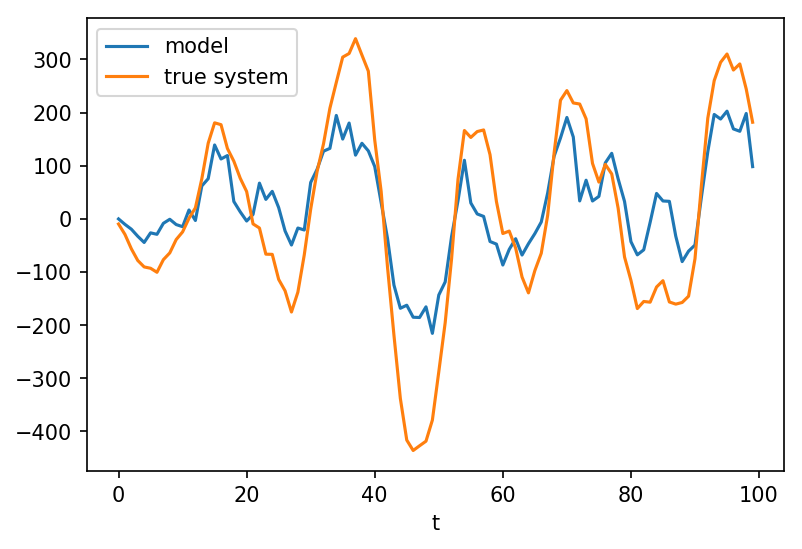

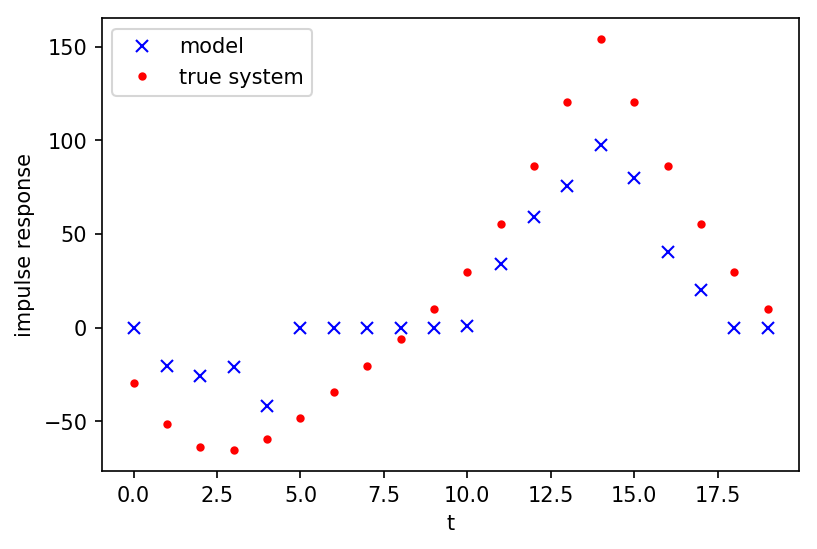

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
import matplotlib.pyplot as plt

m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function, dict_type=dict_type)

alg = AdaptiveLazyEntropicDescentAlgorithm(m.dictionary, R=R, constraint='ball')
model_parameters = alg.run(x_est, y_est, G_sq_eq)

m.set_parameters(model_parameters)
                   
y_ed = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_ed[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()


x = [1] + [0] * (sys_imp_resp_length + 4)
plt.rcParams['figure.dpi'] = 150
plt.plot(m.evaluate_output(x), 'bx')
plt.plot(true_sys.evaluate_output(x), 'r.')
plt.xlabel('t')
plt.ylabel('impulse response')
plt.legend(['model', 'true system'])
plt.show()

print(x)

## Aggregation algorithm

The algorithm aims to estimate Volterra model's parameters on an $\ell_1$-ball of radius $R$. 
Since, we know the $\ell_1$-norm of the true system's parameters we can choose optimal $R$.  

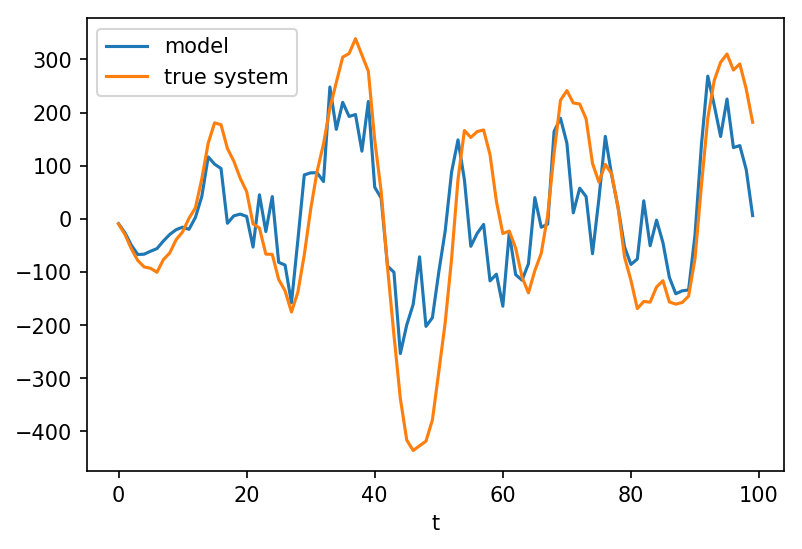

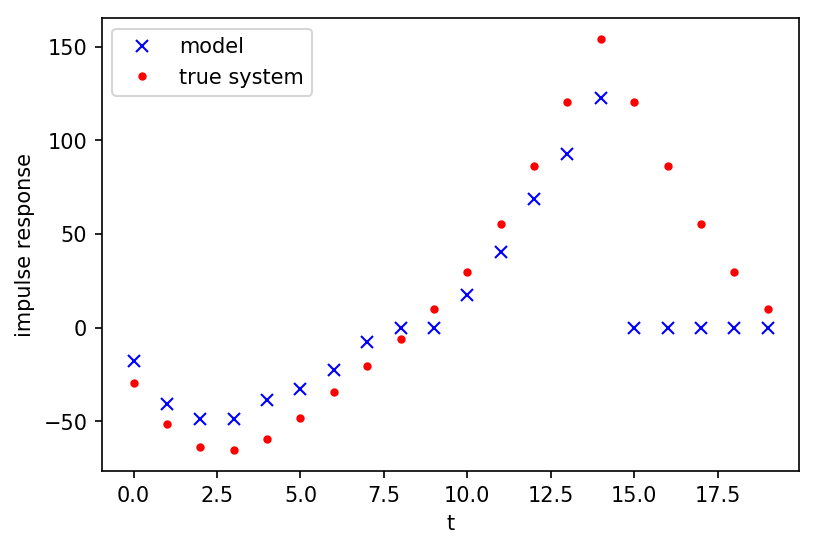

In [27]:
from aggregation import *
import matplotlib.pyplot as plt

# model parameters
model_order = 1
model_memory_len = sys_imp_resp_length
m = VolterraModel(model_order, model_memory_len)

params = aggregation_for_volterra(m.dictionary, x_est, y_est, R=R)
m.set_parameters(params)

y_aggr = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_aggr[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()

x = [1] + [0] * (sys_imp_resp_length + 4)
plt.rcParams['figure.dpi'] = 150
plt.plot(m.evaluate_output(x), 'bx')
plt.plot(true_sys.evaluate_output(x), 'r.')
plt.xlabel('t')
plt.ylabel('impulse response')
plt.legend(['model', 'true system'])
plt.show()
